In [205]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [206]:
def get_perplexity_score(counterfactual_perplexity, original_perplexity):
    ratio = counterfactual_perplexity / original_perplexity
    midpoint = 2
    steepness = 3
    score = 1 / (1 + np.exp(steepness * (ratio - midpoint)))
    score = max(0.01, score)
    return score

def calculate_metrics(df, successful_counterfactuals_only, calculate_perplexity_score):
    if successful_counterfactuals_only:
        df = df[df["found_flip"] == True]

    if calculate_perplexity_score:
        perplexity_score = df.apply(lambda row: get_perplexity_score(row["counterfactual_perplexity"], row["original_perplexity"]), axis=1)
    else:
        perplexity_score = df["counterfactual_perplexity"].dropna()

    metrics = {
        "label_flip_score": df["found_flip"],
        "sparsity_score": df["levenshtein_similarity_score"],
        "perplexity_score": perplexity_score
    }

    return {key: value for key, value in metrics.items()}

def calculate_confidence_interval(data, precision, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return np.round(h, precision)

def process_csv_files(directory, dataset, dataset_size, successful_counterfactuals_only, median, precision, calculate_perplexity_score):
    data = {
        "method_name": [],
        "label_flip_score": [],
        "sparsity_score": [],
        "perplexity_score": [],
        "label_flip_score_ci": [],
        "sparsity_score_ci": [],
        "perplexity_score_ci": []
    }

    methods = ["HOTFLIP", "CLOSS", "POLYJUICE", "FIZLENAIVE", "FIZLEGUIDED"]

    for method in methods:
        filename = f"{method.lower()}-output-{dataset}-{dataset_size}.csv"
        if filename in os.listdir(directory):
            data["method_name"].append(method)
            df = pd.read_csv(os.path.join(directory, filename))
            metrics = calculate_metrics(df, successful_counterfactuals_only, calculate_perplexity_score)
            for key in ["label_flip_score", "sparsity_score", "perplexity_score"]:
                if key == "perplexity_score":
                    metric = np.median(metrics[key])
                else:
                    metric = np.mean(metrics[key]) if not median else np.median(metrics[key])
                metric = np.round(metric, precision)
                data[key].append(metric)
                data[f"{key}_ci"].append(calculate_confidence_interval(metrics[key], precision))

    return data


In [212]:
dataset_size = 100
output_dir = "../output"

successful_counterfactuals_only = False
precision = 3
median = False
calculate_perplexity_score = False

dataset = "sst_2"
print(f"Dataset: {dataset}:")
data = process_csv_files(output_dir, dataset, dataset_size, successful_counterfactuals_only, median, precision, calculate_perplexity_score)
df_sst = pd.DataFrame(data).set_index("method_name")
display(df_sst)
print("\n" + "="*50 + "\n")

dataset = "qnli"
print(f"Dataset: {dataset}:")
data = process_csv_files(output_dir, dataset, dataset_size, successful_counterfactuals_only, median, precision, calculate_perplexity_score)
df_qnli = pd.DataFrame(data).set_index("method_name")
display(df_qnli)
print("\n" + "="*50 + "\n")


Dataset: sst_2:


,label_flip_score,sparsity_score,perplexity_score,label_flip_score_ci,sparsity_score_ci,perplexity_score_ci
method_name,,,,,,
HOTFLIP,0.63,0.870,534.406,0.096,0.016,5703.130
CLOSS,0.67,0.791,408.800,0.095,0.035,6352.732
POLYJUICE,0.40,0.505,111.836,0.098,0.059,3469.291
FIZLENAIVE,0.94,0.698,258.312,0.047,0.037,12421.781
FIZLEGUIDED,0.93,0.704,272.925,0.051,0.040,8364.039




Dataset: qnli:


,label_flip_score,sparsity_score,perplexity_score,label_flip_score_ci,sparsity_score_ci,perplexity_score_ci
method_name,,,,,,
HOTFLIP,0.84,0.915,142.377,0.073,0.015,53.421
CLOSS,0.41,0.969,94.552,0.098,0.004,11.451
POLYJUICE,0.30,0.708,84.941,0.091,0.035,15.744
FIZLENAIVE,0.39,0.798,70.212,0.097,0.034,8.857
FIZLEGUIDED,0.25,0.864,84.187,0.086,0.041,39.199


In [208]:
%pwd

'/Users/smcaleese/Documents/masters-thesis-code/analysis'

In [209]:
import pandas as pd

def dataframe_to_latex_table(df_sst, df_qnli):
    methods = df_qnli.index
    metrics = ["label_flip_score", "sparsity_score", "perplexity_score"]

     # Determine the best values for each metric in each dataset
    best_values = {}
    for df_name, df in [("sst_2", df_sst), ("qnli", df_qnli)]:
        best_values[df_name] = {}
        for metric in metrics:
            if metric == "label_flip_score" or metric == "sparsity_score":  # Higher is better
                best_values[df_name][metric] = df[metric].max()
            else:  # Lower is better
                best_values[df_name][metric] = df[metric].min()

    # Start the LaTeX table
    latex_table = r"""\begin{table}
    \centering
    \small
    \setlength{\tabcolsep}{5pt}
    \begin{tabular}{|l|ccc|ccc|}
    \hline
    \multirow{2}{*}{\textbf{Method}} & \multicolumn{3}{c|}{\textbf{SST-2}} & \multicolumn{3}{c|}{\textbf{QNLI}} \\
    \cline{2-7}
    & LFS $\uparrow$ & Lev. Sim. $\uparrow$ & Perplexity $\downarrow$ & LFS $\uparrow$ & Lev. Sim. $\uparrow$ & Perplexity $\downarrow$ \\
    \hline
    """

    # Add data rows
    for method in methods:
        row = f"{method} "
        for df_name, df in [("sst_2", df_sst), ("qnli", df_qnli)]:
            for metric in metrics:
                value = df.loc[method, metric]
                if np.isclose(value, best_values[df_name][metric]):
                    row += f"& \\textbf{{{value:.2f}}} "
                else:
                    row += f"& {value:.2f} "
        row += r"\\"
        latex_table += row + "\n    \\hline\n    "

    # Close the table
    latex_table += r"""\end{tabular}
\end{table}"""

    return latex_table

latex_output = dataframe_to_latex_table(df_sst, df_qnli)
print(latex_output)

\begin{table}
    \centering
    \small
    \setlength{\tabcolsep}{5pt}
    \begin{tabular}{|l|ccc|ccc|}
    \hline
    \multirow{2}{*}{\textbf{Method}} & \multicolumn{3}{c|}{\textbf{SST-2}} & \multicolumn{3}{c|}{\textbf{QNLI}} \\
    \cline{2-7}
    & LFS $\uparrow$ & Lev. Sim. $\uparrow$ & Perplexity $\downarrow$ & LFS $\uparrow$ & Lev. Sim. $\uparrow$ & Perplexity $\downarrow$ \\
    \hline
    HOTFLIP & 0.63 & \textbf{0.87} & 534.41 & \textbf{0.84} & 0.92 & 142.38 \\
    \hline
    CLOSS & 0.67 & 0.79 & 408.80 & 0.41 & \textbf{0.97} & 94.55 \\
    \hline
    FIZLENAIVE & \textbf{0.94} & 0.70 & 258.31 & 0.39 & 0.80 & \textbf{70.21} \\
    \hline
    FIZLEGUIDED & 0.93 & 0.70 & 272.93 & 0.25 & 0.86 & 84.19 \\
    \hline
    \end{tabular}
\end{table}


In [210]:
df = df_sst

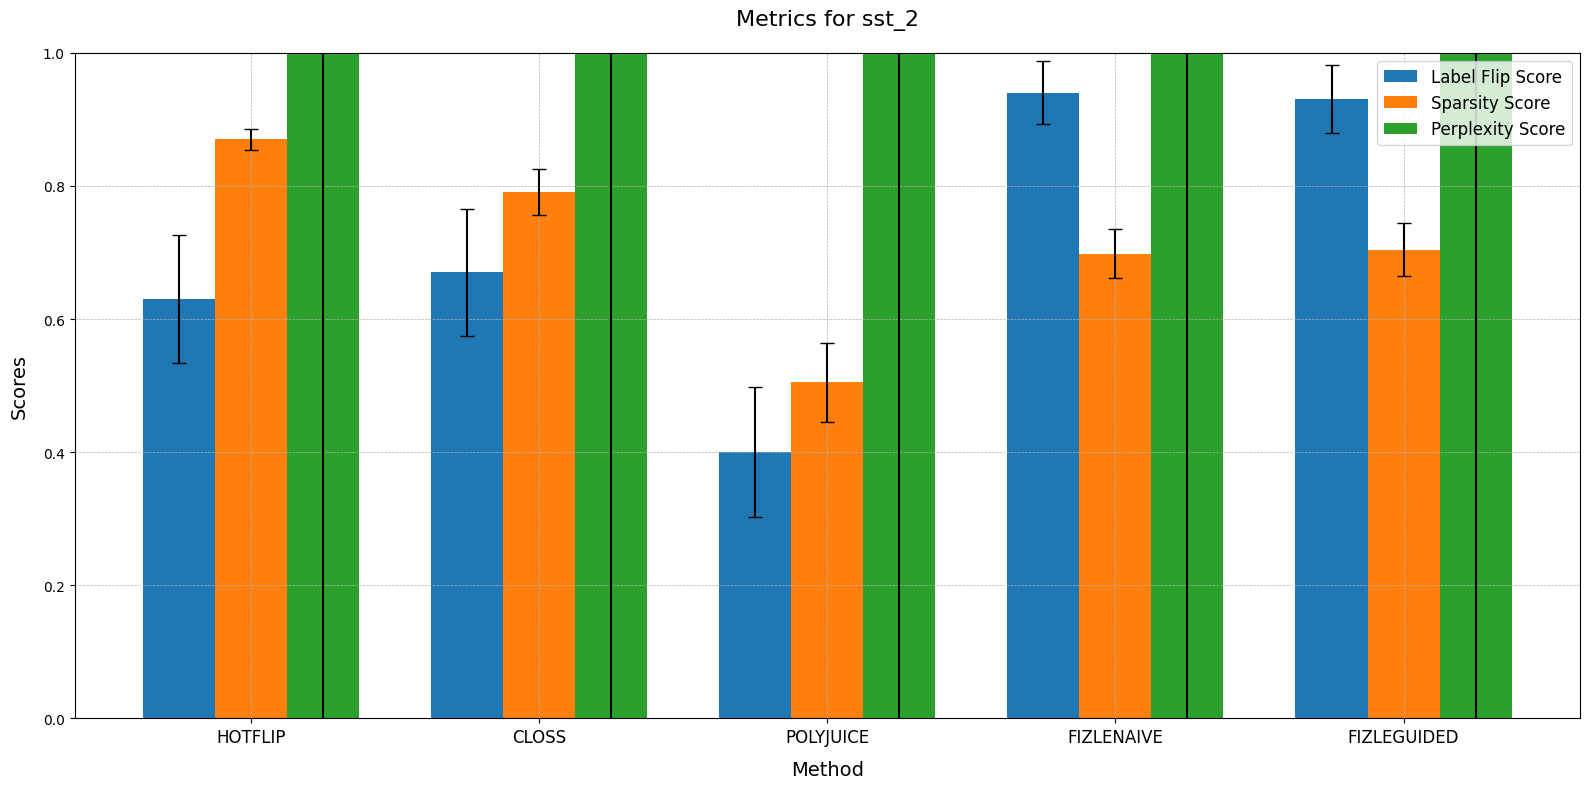

In [211]:
import datetime

# Plotting
plt.style.use("default")
fig, ax = plt.subplots(figsize=(16, 8))

bar_width = 0.25
index = np.arange(len(df.index))

for i, metric in enumerate(["label_flip_score", "sparsity_score", "perplexity_score"]):
    ax.bar(index + i*bar_width, df[metric], bar_width,
           yerr=df[f"{metric}_ci"], capsize=5, 
           label=metric.replace("_", " ").title())

ax.set_title(f"Metrics for {dataset}", fontsize=16, pad=20)
ax.set_xlabel("Method", fontsize=14, labelpad=10)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(df.index.str.upper(), rotation=0, ha="center", fontsize=12)
ax.set_ylabel("Scores", fontsize=14, labelpad=10)
ax.set_ylim([0, 1])
ax.legend(fontsize=12)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
current_date = datetime.date.today().strftime("%Y-%m-%d")
plt.savefig(f"images/results-{dataset}-{dataset_size}-with-ci-{current_date}.png", dpi=300)
plt.show()